## 0. before work

```
you must run ../data_prepare/data_prepare.ipynb to create rec dataset firstly
and then run this train file
```

## 1. import package and set global var

In [5]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from mxnet import metric
from mxnet.gluon import model_zoo

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist, evaluate_MAP, draw_ROC

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 256, 256)
batch_size = 4
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])
std = np.array([58.395, 57.12, 57.375])

ctx = mx.gpu(0)
resize = (data_shape[1], data_shape[2])

## 2. load data and plot data
```
ImageDetIter will call CreateDetAugmenter
if mean==True, it will sub defualt mean
if std==True, it will div default std

both mean and std can not set to False.

or you can cal them and set them as np.array([r, g, b])

在数据中加入rand_crop，添加多尺度信息
```

In [2]:
?? image.CreateDetAugmenter

In [6]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        std=True,
        rand_crop=1,
        rand_gray=0.2,
        rand_mirror=True,
        rand_pad=0.4,
        pad_val=(rgb_mean[0], rgb_mean[1], rgb_mean[2]),
        min_object_covered=0.95,
        max_attempts=200,
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05,
        aspect_ratio_range=(0.5, 2),
        pca_noise=0.01,
    )
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

rec_prefix = sdl_root+"rec/sdl_" + str(resize[0]) + "_" + str(resize[1])
train_data, valid_data, class_names, num_class = get_iterators(rec_prefix, data_shape, batch_size)
    

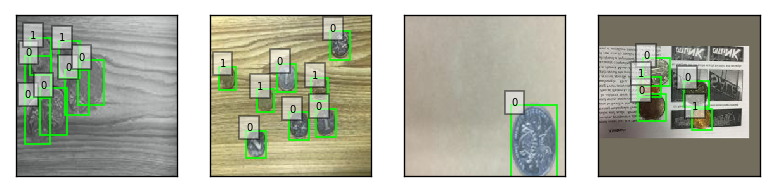

(4L, 14L, 5L)


In [7]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:4]
labels = batch.label[0][:4]

show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, std, show_text=True, fontsize=6, MN=(2, 4))
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## 3. 在模型中添加多尺度
```
根据数据中bbox的分布, 修改模型的size_list
    sizes_list = [[0.1, 0.2], [.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
  给模型添加更前面的一个层用于预测
  框的加入，带来多尺度的同时也很可能提高误检率，因此这是一个权衡问题，一般和SSD作者一样选择5个尺度
  会降低定位误差，但是也会降低分类的得分。
```

In [9]:
"""
model define
"""

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def get_vgg11bn_conv(ctx):
    vgg11bnnet = model_zoo.vision.vgg11_bn(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(vgg11bnnet.features[:15]))
    sampler = gluon.nn.HybridSequential()
    sampler.add(*(vgg11bnnet.features[15: 22]))
    return net, [sampler]

def get_mobilenet_1_conv(ctx):
    mobilenet = model_zoo.vision.mobilenet1_0()
    net = gluon.nn.HybridSequential()
    net.add(*mobilenet.features[:33])
    net.initialize(ctx=ctx)
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
#             self.body = nn.HybridSequential()
#             for filters in [16, 32, 64]:
#                 self.body.add(down_sample(filters))
            # self.body = get_vgg11bn_conv(ctx)
            self.body, samplers = get_vgg11bn_conv(ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            self.downsamples.add(*samplers)
            for _ in range(len(sizes_list) - 2 - len(samplers)):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(len(sizes_list)):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(len(self.sizes_list)):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < len(self.sizes_list) - 2:
                x = self.downsamples[i](x)
            elif i == len(self.sizes_list) - 2:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[0.1, 0.2], [.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*len(sizes_list)

根据数据中bbox的分布, 修改模型的size_list
    sizes_list = [[0.1, 0.2], [.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
  给模型添加更前面的一个层用于预测
  框的加入，带来多尺度的同时也很可能提高误检率，因此这是一个权衡问题，一般和SSD作者一样选择5个尺度
  会降低定位误差，但是也会降低分类的得分。

In [10]:
"""
model define
"""

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def get_vgg11bn_conv(ctx):
    vgg11bnnet = model_zoo.vision.vgg11_bn(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(vgg11bnnet.features[:22]))
    return net

def get_mobilenet_1_conv(ctx):
    mobilenet = model_zoo.vision.mobilenet1_0()
    net = gluon.nn.HybridSequential()
    net.add(*mobilenet.features[:33])
    net.initialize(ctx=ctx)
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
#             self.body = nn.HybridSequential()
#             for filters in [16, 32, 64]:
#                 self.body.add(down_sample(filters))
            # self.body = get_vgg11bn_conv(ctx)
            self.body = get_vgg11bn_conv(ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(len(sizes_list) - 2):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(len(sizes_list)):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(len(self.sizes_list)):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < len(self.sizes_list) - 2:
                x = self.downsamples[i](x)
            elif i == len(self.sizes_list) - 2:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
sizes_list = [[ 0.10416667 ,0.17361111], [0.18624024, 0.34354575], [.37,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*len(sizes_list)

In [11]:
import time
net = SSD(2, sizes_list, ratios_list, ctx=mx.cpu(), verbose=True, prefix="ssd_")
print net
#net.initialize()
tic = time.time()
anchors, box_preds, cls_preds = net(batch.data[0])
print time.time() - tic
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, batch.label[0], cls_preds.transpose(axes=(0, 2, 1)))
print cls_labels.shape, cls_preds.shape, box_offset.shape, box_mask.shape

SSD(
  (downsamples): HybridSequential(
    (0): HybridSequential(
      (0): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (2): Activation(relu)
      (3): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
    (1): HybridSequential(
      (0): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (2): Activation(relu)
      (3): Conv2D(128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(fix_gamma=False, eps=1e-05, momentum=0.9, axis=1, in_channels=128)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(

In [12]:
"""
loss define
"""
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gama=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self.alpha = alpha
        self.gama = gama
        self.axis = axis
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label):
        y = F.softmax(y)
        py = y.pick(label, axis=self.axis, keepdims=True)
        loss = - (self.alpha * ((1 - py) ** self.gama)) * py.log()
        return loss.mean(axis=self.batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label, mask):
        loss = F.smooth_l1((y - label) * mask, scalar=1.0)
        return loss.mean(axis=self.batch_axis, exclude=True)
    
cls_loss = FocalLoss()
#cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
box_loss = SmoothL1Loss()

## 根据数据制定自定义的大小框带来增益
```
框的定位误差明显减下来了，同时AP value升上去了， 但是测试的时候发现得分降下来了，但是负框分数减少更多，左后效果更好了

epoch: 9 time: 2.63 loss: 0.0932, 0.1250 lr: 0.5000 train mae: 0.0089 AP: 0.5121 valid mae: 0.0075 AP: 0.6335
epoch: 19 time: 2.57 loss: 0.0686, 0.0840 lr: 0.5000 train mae: 0.0067 AP: 0.6982 valid mae: 0.0060 AP: 0.7421
epoch: 29 time: 2.54 loss: 0.0551, 0.0687 lr: 0.5000 train mae: 0.0057 AP: 0.7258 valid mae: 0.0051 AP: 0.8263
epoch: 39 time: 2.58 loss: 0.0536, 0.0704 lr: 0.5000 train mae: 0.0058 AP: 0.7310 valid mae: 0.0046 AP: 0.8303
epoch: 49 time: 2.57 loss: 0.0517, 0.0616 lr: 0.5000 train mae: 0.0052 AP: 0.7457 valid mae: 0.0040 AP: 0.8826
epoch: 59 time: 2.66 loss: 0.0468, 0.0536 lr: 0.5000 train mae: 0.0050 AP: 0.7925 valid mae: 0.0036 AP: 0.8773
epoch: 69 time: 2.56 loss: 0.0468, 0.0512 lr: 0.5000 train mae: 0.0049 AP: 0.7923 valid mae: 0.0033 AP: 0.9046
epoch: 79 time: 2.54 loss: 0.0435, 0.0497 lr: 0.5000 train mae: 0.0045 AP: 0.7946 valid mae: 0.0032 AP: 0.8702
epoch: 89 time: 2.58 loss: 0.0416, 0.0454 lr: 0.5000 train mae: 0.0044 AP: 0.7972 valid mae: 0.0029 AP: 0.8996
epoch: 99 time: 2.63 loss: 0.0412, 0.0364 lr: 0.5000 train mae: 0.0039 AP: 0.8373 valid mae: 0.0028 AP: 0.8872
epoch: 109 time: 2.60 loss: 0.0378, 0.0361 lr: 0.2500 train mae: 0.0037 AP: 0.8247 valid mae: 0.0028 AP: 0.8919
epoch: 119 time: 2.58 loss: 0.0420, 0.0404 lr: 0.2500 train mae: 0.0042 AP: 0.8245 valid mae: 0.0027 AP: 0.8929
epoch: 129 time: 2.71 loss: 0.0391, 0.0387 lr: 0.2500 train mae: 0.0041 AP: 0.8099 valid mae: 0.0026 AP: 0.9034
epoch: 139 time: 2.68 loss: 0.0405, 0.0373 lr: 0.2500 train mae: 0.0040 AP: 0.8412 valid mae: 0.0026 AP: 0.9008
epoch: 149 time: 2.59 loss: 0.0371, 0.0339 lr: 0.2500 train mae: 0.0037 AP: 0.8212 valid mae: 0.0026 AP: 0.9008
epoch: 159 time: 2.62 loss: 0.0382, 0.0355 lr: 0.1250 train mae: 0.0038 AP: 0.8200 valid mae: 0.0025 AP: 0.9021
epoch: 169 time: 2.58 loss: 0.0382, 0.0359 lr: 0.1250 train mae: 0.0038 AP: 0.8207 valid mae: 0.0025 AP: 0.9034
epoch: 179 time: 2.55 loss: 0.0392, 0.0358 lr: 0.1250 train mae: 0.0038 AP: 0.8279 valid mae: 0.0026 AP: 0.9021
epoch: 189 time: 2.60 loss: 0.0371, 0.0340 lr: 0.0625 train mae: 0.0037 AP: 0.8083 valid mae: 0.0025 AP: 0.9048
epoch: 199 time: 2.62 loss: 0.0397, 0.0375 lr: 0.0625 train mae: 0.0039 AP: 0.8037 valid mae: 0.0025 AP: 0.9048
```

In [13]:
"""
train net
"""

def evaluate_acc(data_iter, ctx):
    data_iter.reset()
    box_metric = metric.MAE()
    outs, labels = None, None
    for i, batch in enumerate(data_iter):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        anchors, box_preds, cls_preds = net(data)
        box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                                  negative_mining_ratio=3.0)#, overlap_threshold=0.75)
        box_metric.update([box_offset], [box_preds * box_mask])
        
        cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
        out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
        if outs is None:
            outs = out
            labels = label
        else:
            outs = nd.concat(outs, out, dim=0)
            labels = nd.concat(labels, label, dim=0)
    AP = evaluate_MAP(outs, labels)
    return AP, box_metric
        
info = {"train_ap": [], "valid_ap": [], "loss": []}
def train(net, start_epoch, end_epoch, trainer=None):
    if trainer is None:
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5, 'wd': 5e-4})
    box_metric = metric.MAE()
    
    for e in range(start_epoch, end_epoch):
        train_data.reset()
        box_metric.reset()
        tic = time.time()
        _loss = [0,0]
        if e == 100 or e == 150 or e==180:
#         if e == 150 or e==180:
            trainer.set_learning_rate(trainer.learning_rate * 0.5)
            
        outs, labels = None, None
        for i, batch in enumerate(train_data):
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                anchors, box_preds, cls_preds = net(data)
                box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                                  negative_mining_ratio=3.0)#, overlap_threshold=0.75)
                loss1 = cls_loss(cls_preds, cls_labels)
                loss2 = box_loss(box_preds, box_offset, box_mask)
                loss = loss1 + loss2
            loss.backward()
            trainer.step(data.shape[0])
            _loss[0] += nd.mean(loss1).asscalar()
            _loss[1] += nd.mean(loss2).asscalar()
            
            cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
            out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
            if outs is None:
                outs = out
                labels = label
            else:
                outs = nd.concat(outs, out, dim=0)
                labels = nd.concat(labels, label, dim=0)
            
            box_metric.update([box_offset], [box_preds * box_mask])
        
        train_AP = evaluate_MAP(outs, labels)
        valid_AP, val_box_metric = evaluate_acc(valid_data, ctx)
        info["train_ap"].append(train_AP)
        info["valid_ap"].append(valid_AP)
        info["loss"].append(_loss)
        
        if (e+1) % 10 == 0:
            print "epoch: %d time: %.2f loss: %.4f, %.4f lr: %.4f" % (e, time.time() - tic,_loss[0], _loss[1], trainer.learning_rate),
            print "train mae: %.4f AP: %.4f" % (box_metric.get()[1], train_AP),
            print "valid mae: %.4f AP: %.4f" % (val_box_metric.get()[1], valid_AP)

net = SSD(2, sizes_list, ratios_list, ctx, verbose=False, prefix="ssd_")
# net.collect_params().initialize(ctx=ctx, force_reinit=True)
train(net, 0, 200)

epoch: 9 time: 2.82 loss: 0.0930, 0.1104 lr: 0.5000 train mae: 0.0080 AP: 0.4981 valid mae: 0.0072 AP: 0.5978
epoch: 19 time: 2.58 loss: 0.0725, 0.0940 lr: 0.5000 train mae: 0.0072 AP: 0.6259 valid mae: 0.0056 AP: 0.7458
epoch: 29 time: 2.59 loss: 0.0590, 0.0719 lr: 0.5000 train mae: 0.0059 AP: 0.7047 valid mae: 0.0049 AP: 0.7947
epoch: 39 time: 2.63 loss: 0.0532, 0.0638 lr: 0.5000 train mae: 0.0053 AP: 0.7239 valid mae: 0.0042 AP: 0.8633
epoch: 49 time: 2.59 loss: 0.0486, 0.0593 lr: 0.5000 train mae: 0.0053 AP: 0.7639 valid mae: 0.0039 AP: 0.8731
epoch: 59 time: 2.64 loss: 0.0465, 0.0545 lr: 0.5000 train mae: 0.0051 AP: 0.7902 valid mae: 0.0036 AP: 0.8223
epoch: 69 time: 2.59 loss: 0.0431, 0.0452 lr: 0.5000 train mae: 0.0045 AP: 0.8017 valid mae: 0.0034 AP: 0.8155
epoch: 79 time: 2.62 loss: 0.0427, 0.0429 lr: 0.5000 train mae: 0.0043 AP: 0.8035 valid mae: 0.0031 AP: 0.8494
epoch: 89 time: 2.61 loss: 0.0404, 0.0439 lr: 0.5000 train mae: 0.0042 AP: 0.8160 valid mae: 0.0030 AP: 0.8592
ep

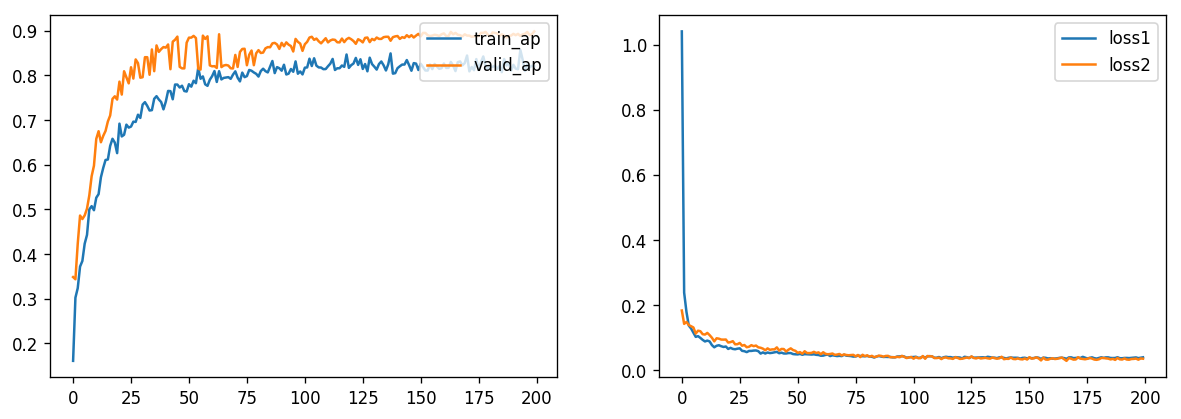

In [14]:
def plot(key):
    plt.plot(range(len(info[key])), info[key], label=key)


info["loss"] = np.array(info["loss"])
info["loss1"] = info["loss"][:, 0]
info["loss2"] = info["loss"][:, 1]

plt.figure(figsize=(12, 4))   # (w, h)
plt.subplot(121)
plot("train_ap")
plot("valid_ap")
plt.legend(loc="upper right")
plt.subplot(122)
plot("loss1")
plot("loss2")
plt.legend(loc="upper right")


In [142]:
mkdir_if_not_exist("../models")
net.save_params("../models/sdl_coin_vgg11bn_256x256_data_sizes.param")

## 可视化测试结果

(92L, 1364L, 6L)
(92L, 14L, 5L)
0.813110957052


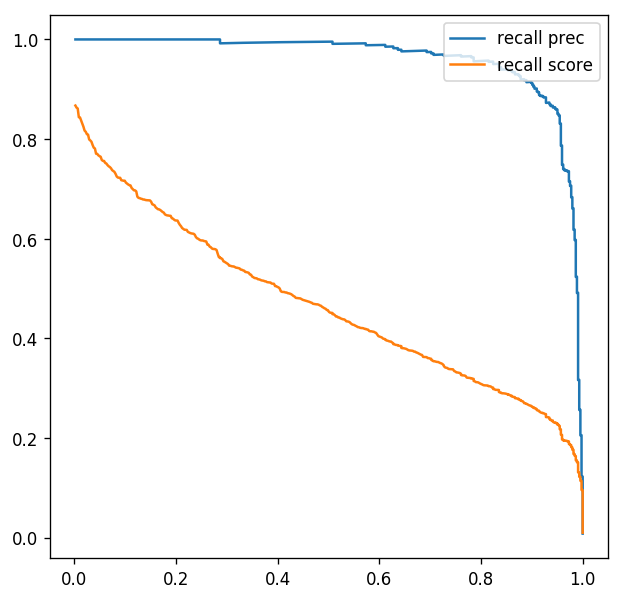

In [124]:
train_data.reset()
outs = None
labels = None
for i, batch in enumerate(train_data):
    data = batch.data[0].as_in_context(ctx)
    label = batch.label[0].as_in_context(ctx)
    anchors, box_preds, cls_preds = net(data)
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode="channel")
    out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
    if outs is None:
        outs = out
        labels = label
    else:
        outs = nd.concat(*[outs, out], dim=0)
        labels = nd.concat(*[labels, label], dim=0)

print outs.shape
print labels.shape
print evaluate_MAP(outs, labels)
draw_ROC(outs, labels, verbose=True)

In [43]:
from utils.utils import find_best_score_th
score_th = find_best_score_th(outs.asnumpy(), labels.asnumpy())
print score_th

0.974642


In [10]:
net = SSD(2, sizes_list, ratios_list, ctx=ctx, verbose=False, prefix="ssd_")
net.load_params("../models/sdl_coin_vgg11bn_256x256_data_sizes.param", ctx=ctx)

In [8]:
valid_data = image.ImageDetIter(
    batch_size=batch_size, 
    data_shape=data_shape,
    path_imgrec=sdl_root+"rec/sdl"+'_val.rec',
    path_imgidx=sdl_root+"rec/sdl"+'_val.idx',
    shuffle=True,
    mean=True,
    std=True,
)

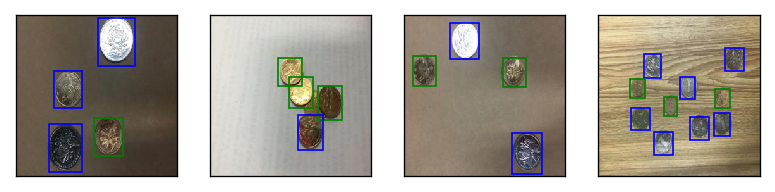

In [14]:
from utils.utils import show_det_results
from mxnet.contrib.ndarray import MultiBoxDetection

mpl.rcParams['figure.figsize'] = (6, 6)
datas = valid_data
try:
    batch = datas.next()
except Exception:
    datas.reset()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)), negative_mining_ratio=3)

imgs = (data.transpose((0, 2, 3, 1)).asnumpy() * std)+ rgb_mean
#plt.imshow(imgs[0] / 255)
show_det_results(imgs, out, threshold=0.30, show_text=False, MN=(2, 4))